# Model Interpretability 
Which pixels of the input image are the most salient for the classification task?


In [1]:
# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

import sys

sys.path.insert(0, "..")
import plotting_utils
from plotting_utils import config
from tueplots import figsizes

config.experiment_name = "model_interpretability"
config.target = "nyu"
config.debug_mode = True

plt.rcParams.update(config.tueplots_bundle())

# Data Wrangling
import pandas as pd

# Machine Learning
import numpy as np
import torch

# Project 
from data.car_dataset import (
    CarDataset,
    data_transforms,
    inverse_transform,
    year2label_fn,
)
from data.data_splitting import split_dataset_dfs

In [2]:
# load dataframes
features_df = pd.read_csv("../../raw_data/tables/features.csv")
train_df, val_df, test_df = split_dataset_dfs("../../raw_data/tables/features.csv")

In [3]:
min_year = features_df["Launch_Year"].min()  # oldest car launch_year in data
max_year = features_df["Launch_Year"].max()
year_bucket_size = 2

In [4]:
# create dataset
train_set = CarDataset(
    features=train_df,
    transform=data_transforms["train"],
    year2label_fn=lambda year: year2label_fn(
        year, min_year=min_year, max_year=max_year, year_bucket_size=year_bucket_size
    ),
    img_root_dir="../../raw_data/",
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


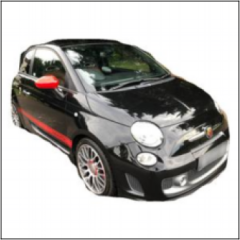

In [5]:
# create image tensors
torch.manual_seed(42)  # Needed to fix (random) data augmentation

img_tens, _, _, _, _, _, _ = train_set[0]
img_tens = img_tens.unsqueeze(0)

with plt.rc_context(config.tueplots_bundle(rel_width=1.0)):
    plotting_utils.imshow(img_tens.detach())

    plotting_utils.savefig(
        f"car",
        extension="png",
        dpi=300,
        bbox_inches="tight",
        pad_inches=0.01,
    )

## Saliency Map

In [6]:
# Select model
from models import get_pretrained_model, get_fine_tuned_model

model = get_fine_tuned_model(
    num_classes=1 + ((max_year - min_year) // year_bucket_size),
    path_to_weights="../model_weights.pt",
)
# model = get_pretrained_model()


# Turn off the gradients since we are using a trained model
for param in model.parameters():
    param.requires_grad = False

# Set the model to evaluation mode
model.eval()

# Saliency map: Calculate gradients of model output wrt input

# Need gradients wrt input image
img_tens.requires_grad = True


# Optional improvement: "Guided backpropagation" (https://www.coderskitchen.com/guided-backpropagation-with-pytorch-and-tensorflow/)
# Idea: zero out negative gradients of ReLU layers
def relu_hook_function(module, grad_in, grad_out):
    """Zero out negative gradients for any ReLU units in backward pass."""
    if isinstance(module, torch.nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.0),)


for i, module in enumerate(model.modules()):
    """Modify backward pass with ReLU hook."""
    if isinstance(module, torch.nn.ReLU):
        module.register_backward_hook(relu_hook_function)

# Forward pass to calculate predictions
preds = model(img_tens)
score, indices = torch.max(preds, 1)

# Backward pass to get gradients of class scores wrt input image
score.backward()

# Compute saliency map
# slc, _ = torch.max(torch.abs(img_tens.grad[0]), dim=0)

slc, _ = torch.max(torch.clamp(img_tens.grad[0], min=0.0), dim=0)
slc = (slc - slc.min()) / (slc.max() - slc.min())  # normalize

/Users/hanna/.virtualenvs/cogneuro/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


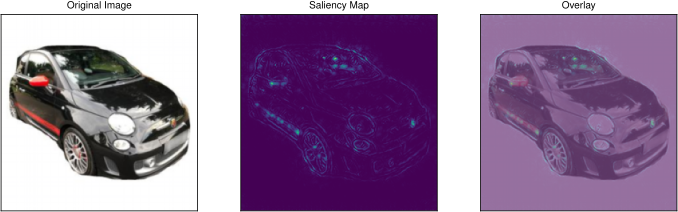

In [7]:
# Plot saliency map
with plt.rc_context(config.tueplots_bundle(rel_width=1.0, ncols=3)):
    fig, axs = plt.subplots(
        nrows=1, ncols=3, figsize=(10, 3), sharex="row", sharey="row"
    )

    input_transformed_for_plot = np.transpose(
        inverse_transform(img_tens).detach().numpy().squeeze(),
        (1, 2, 0),
    )

    axs[0].imshow(input_transformed_for_plot)
    axs[1].imshow(slc, cmap="viridis")
    # overly input image with saliency map
    axs[2].imshow(input_transformed_for_plot, alpha=0.75)
    axs[2].imshow(slc, alpha=0.75)

    axs[0].set(title="Original Image")
    axs[1].set(title="Saliency Map")
    axs[2].set(title="Overlay")
    for ax in axs:
        # Hide X and Y axes label marks
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)

        # Hide X and Y axes tick marks
        ax.set_xticks([])
        ax.set_yticks([])

    plotting_utils.savefig(
        f"saliency_map",
        extension="png",
        dpi=300,
        bbox_inches="tight",
        pad_inches=0.01,
    )